# Quantum Teleportation Demonstrator
## now with (simulated) real quantum magic!

# Overview

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state |𝜓⟩=𝛼|0⟩+𝛽|1⟩
. This entails passing on information about 𝛼 and 𝛽 to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of |𝜓⟩ and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state |𝜓⟩ to Bob. We call this teleportation as at the end Bob will have |𝜓⟩ and Alice won't anymore.

# The Quantum Teleportation Protocol

Alice and Bob share an EPR pair (Bell state) and each took one qubit before they became separated. Alice must deliver a qubit of information to Bob, but she does not know the state of this qubit and can only send classical information to Bob. 

To transfer a quantum bit, Alice and Bob must establish:
1. Quantum channel (EPR pair or Bell state)
2. Classical communication channel

Alice them performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

We will describe the steps on a quantum circuit below. Here, no qubits are actually ‘sent’, The status of the Alice qbit will be teleported and then read out by Bob.

First we set up our session:

In [69]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex
import math

Initialize qubits and classical bits for Alice and Bob.

In [70]:
# Alice - two qubits, two classical bits
Alice_Psi = QuantumRegister(1)
Alice_Bell = QuantumRegister(1)
c_Alice_Psi = ClassicalRegister(1)
c_Alice_Bell = ClassicalRegister(1)

# Bob - one qubit, one classical bit
Bob_Bell = QuantumRegister(1)
c_Bob_Bell = ClassicalRegister(1)

Now we have to prepare the input_vector aka wave function psi, to be teleported.
There are three methods to do so:
1. Desired input_vector
2. Randomly generated input_vector
3. Enter a number that will be converted into the input_vactor

You can choose one of the three methods in the following cells.

1. Initialize PSI with desired state

In [81]:
# Initialize PSI with desired state
input_vector = [
    1/2 * complex(1, 0),
    math.sqrt(3/4) * complex(1, 0)
]
psi = input_vector

2. Initialize PSI with random state

In [47]:
# Initialize PSI with random state
psi = random_state(1)

3. Enter a number that will be converted into the input_vactor

In [48]:
A = int(input("please enter a number between 0 and 100  A: "))

please enter a number between 0 and 100  A: 30


In [49]:
# Convert the entered number into wave psi function of the qbit
alpha = A/100
beta = math.sqrt(1-alpha**2)
psi = [alpha, beta]

Show input state (input_vector) psi, that has been entered

<IPython.core.display.Math object>

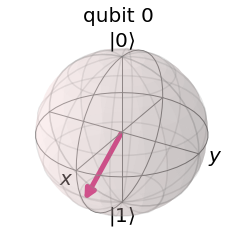

In [82]:
# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =") 

# Show it on a Bloch sphere
plot_bloch_multivector(psi)

Now let us check the input state when it would be measured immediately using statevector simulator

In [83]:
# Initialize qbit Alice-Psi with input_vector psi
qc = QuantumCircuit(Alice_Psi, c_Alice_Psi, name="input_state")
input_state = Initialize(psi)
input_state.label = "Alice Psi"
qc.append(input_state, [Alice_Psi])

# Run the circuit for input_vactor psi 
job = execute(qc, backend=BasicAer.get_backend("statevector_simulator"))
simulated_input_state = job.result().get_statevector()

! For entered number only !

In [74]:
# For entered number only:
simulated_input_number = int(round(abs(simulated_input_state[0])*100))
print("Simulated input number:", simulated_input_number)

Simulated input number: 71


Show the simulated input state. It must be similar to the entered input_vector psi (see above)

<IPython.core.display.Math object>

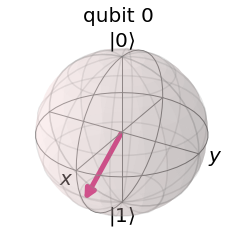

In [84]:
# Display it nicely
array_to_latex(simulated_input_state, pretext="|\\psi\\rangle =") 

# Show it on a Bloch sphere
plot_bloch_multivector(simulated_input_state)

# Let the teleportation begin

## Using statevector simulator

Now we construct an entire teleportation circuit, so we again have to initialize Alice_Psi qbit with input_vector

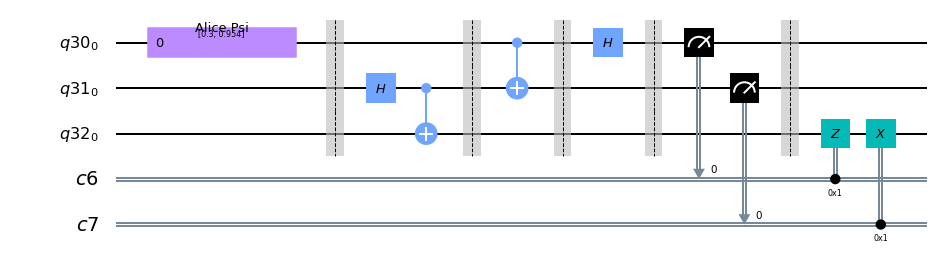

In [54]:
qc = QuantumCircuit(Alice_Psi, Alice_Bell, Bob_Bell, c_Alice_Psi, c_Alice_Bell, name="teleportation")

# Prepare the input state
init_gate = Initialize(psi)
init_gate.label = "Alice Psi"
qc.append(init_gate, [Alice_Psi])

qc.barrier()  # for better drawing

# Prepare an entangled pair (EPR pair) between Alice and Bob
qc.h(Alice_Bell)
qc.cx(Alice_Bell, Bob_Bell)

qc.barrier()  # for better drawing

# Alice to send qubits through CNOT gate
qc.cx(Alice_Psi, Alice_Bell)

qc.barrier()  # for better drawing

# Alice to send first qubit through Hadamard gate
qc.h(Alice_Psi)

qc.barrier()  # for better drawing

# Alice measures her qubits
qc.measure(Alice_Psi, c_Alice_Psi)
qc.measure(Alice_Bell, c_Alice_Bell)

# Transmit results Alice --> Bob on classical channel

qc.barrier()  # for better drawing

# Apply a correction at Bob
qc.z(Bob_Bell).c_if(c_Alice_Psi, 1)
qc.x(Bob_Bell).c_if(c_Alice_Bell, 1)

# Draw the circuit
qc.draw()

! No measurement by Bob, statevector_simulator instead

Simulate the teleportation circuit with the statevector simulator 

In [58]:
backend = BasicAer.get_backend('statevector_simulator')
output_vector = execute(qc, backend).result().get_statevector()
output_vector = -output_vector

Show the teleported state

<IPython.core.display.Math object>

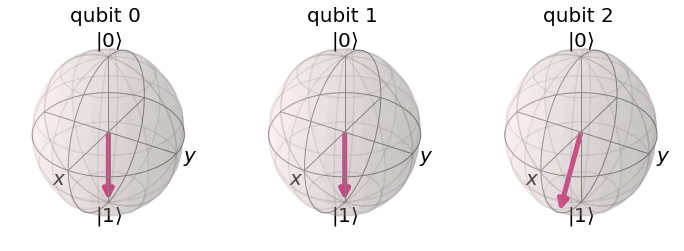

In [59]:
array_to_latex(output_vector, pretext="|\\psi\\rangle =") 
plot_bloch_multivector(output_vector)

# Using the QASM Simulator

Quantum teleportation is designed to send qubits between two parties. We do not have the hardware to demonstrate this, but we can demonstrate that the gates perform the correct transformations on a single quantum chip. Here we use the QASM simulator to simulate how we might test our protocol.

On a real quantum computer, we would not be able to sample the statevector, so if we wanted to check our teleportation circuit is working, we need to do things slightly differently. You will remember that we used Initialize to turn our |0⟩
qubit into the state |𝜓⟩

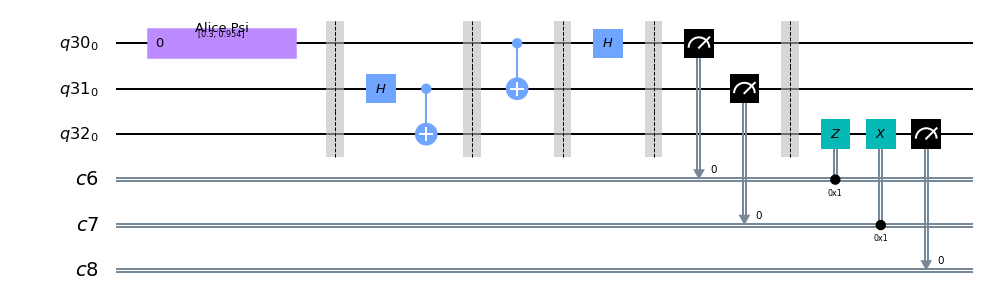

In [60]:
qc = QuantumCircuit(Alice_Psi, Alice_Bell, Bob_Bell, c_Alice_Psi, c_Alice_Bell, c_Bob_Bell, name="teleportation")

# Prepare the initial state
init_gate = Initialize(psi)
init_gate.label = "Alice Psi"
qc.append(init_gate, [Alice_Psi])

qc.barrier()  # for better drawing

# Prepare an entangled pair (EPR pair) between Alice and Bob
qc.h(Alice_Bell)
qc.cx(Alice_Bell, Bob_Bell)

qc.barrier()  # for better drawing

# Alice to send qubits through CNOT gate
qc.cx(Alice_Psi, Alice_Bell)

qc.barrier()  # for better drawing

# Alice to send first qubit through Hadamard gate
qc.h(Alice_Psi)

qc.barrier()  # for better drawing

# Alice measures her qubits
qc.measure(Alice_Psi, c_Alice_Psi)
qc.measure(Alice_Bell, c_Alice_Bell)

# Transmit results Alice --> Bob on classical channel

qc.barrier()  # for better drawing

# Apply a correction at Bob
qc.z(Bob_Bell).c_if(c_Alice_Psi, 1)
qc.x(Bob_Bell).c_if(c_Alice_Bell, 1)

# Measure quantum state by Bob
qc.measure(Bob_Bell, c_Bob_Bell)

qc.draw()

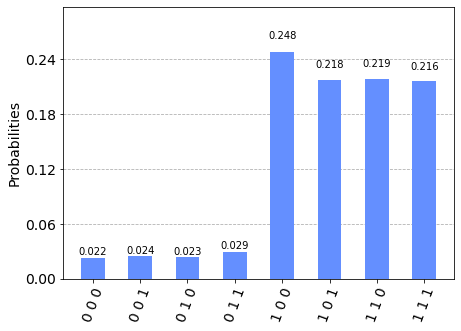

In [61]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
measurement_result = execute(qc, backend, shots=shots).result().get_counts()
plot_histogram(measurement_result)

In [62]:
bob_measurement_result = {}
bob_measurement_result['0'] = 0
bob_measurement_result['1'] = 0
for key, val in measurement_result.items():
    bob_measurement_result[key[0]] += val
print("bob_measurement_result:", bob_measurement_result)

bob_measurement_result: {'0': 102, '1': 922}


In [63]:
output_state = math.sqrt(bob_measurement_result['0']/shots)
Teleported_number = int(round(abs(output_state)*100))
print("Teleported number:", Teleported_number)

Teleported number: 32


# Teleportation on a Real Quantum Computer

IBM hardware and Deferred Measurement

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the deferred measurement principle [1]. The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.

Any benefits of measuring early are hardware related: If we can measure early, we may be able to reuse qubits, or reduce the amount of time our qubits are in their fragile superposition. In this example, the early measurement in quantum teleportation would have allowed us to transmit a qubit state without a direct quantum communication channel.

While moving the gates allows us to demonstrate the "teleportation" circuit on real hardware, it should be noted that the benefit of the teleportation process (transferring quantum states via classical channels) is lost.

Let us re-write the bob_gates function to new_bob_gates:

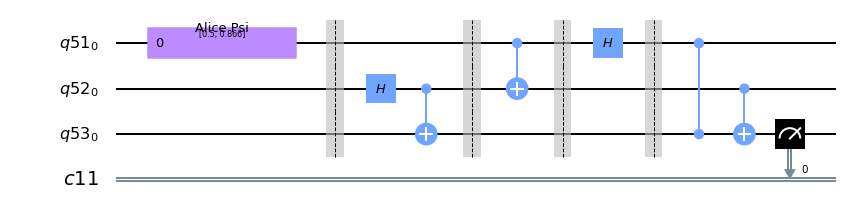

In [86]:
qc = QuantumCircuit(Alice_Psi, Alice_Bell, Bob_Bell, c_Bob_Bell, name="teleportation")

# Prepare the initial state
init_gate = Initialize(psi)
init_gate.label = "Alice Psi"
qc.append(init_gate, [Alice_Psi])

qc.barrier()  # for better drawing

# Prepare an entangled pair (EPR pair) between Alice and Bob
qc.h(Alice_Bell)
qc.cx(Alice_Bell, Bob_Bell)

qc.barrier()  # for better drawing

# Alice to send qubits through CNOT gate
qc.cx(Alice_Psi, Alice_Bell)

qc.barrier()  # for better drawing

# Alice to send first qubit through Hadamard gate
qc.h(Alice_Psi)

qc.barrier()  # for better drawing

# Alice does not measure her qbits. Instead:
# Apply a delayed measurement at Bob
qc.cz(Alice_Psi, Bob_Bell)
qc.cx(Alice_Bell, Bob_Bell)

# Measure quantum state by Bob
qc.measure(Bob_Bell, c_Bob_Bell)

qc.draw()

In [87]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

ibmqfactory.load_account:WARNING:2020-06-30 17:23:51,293: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [88]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
print ("Backend", backend)
shots = 8192
measurement_result = execute(qc, backend=backend, shots=shots).result().get_counts()

Backend ibmq_london


{'1': 5228, '0': 2964}


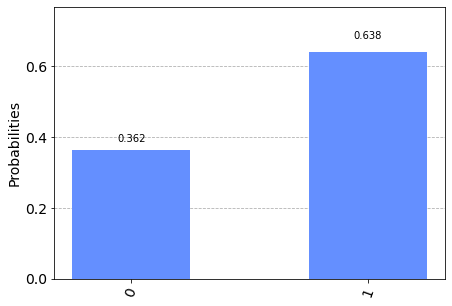

In [89]:
# Display results 
print(measurement_result)
plot_histogram(measurement_result)

! For entered number only !

In [80]:
# For entered number only 
output_state = math.sqrt(measurement_result['0']/shots)
Teleported_number = int(round(abs(output_state)*100))
print("Teleported number:", Teleported_number)

Teleported number: 72


Note: the teleportation result with the real quentum computer is very unsatisfied - the error is huge.
Any kind of improvements are more than desired. 

In [65]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright